In [1]:
from ats9371_for_tomography.ats9371 import AlazarTechATS9371
from ats9371_for_tomography.raw_acq_ctrl import RawAcquisitionController
AlazarTechATS9371.find_boards()

[{'system_id': 1,
  'board_id': 1,
  'board_kind': 'ATS9371',
  'max_samples': 4294967294,
  'bits_per_sample': 12}]

In [2]:
# connect to ATS9371
ats_inst = AlazarTechATS9371(name='ATS9371')
acq_ctrl = RawAcquisitionController(
    name='ATS9371_acq', alazar_name='ATS9371'
)

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
def max_record(n_samples, max_mb=84):
    max_bit = max_mb * 1024 * 1024 * 8
    resolution_bit = 12
    return int(max_bit/ resolution_bit / n_samples)
def acq_size_mb(n_records, n_samples):
    resolution_bit = 12
    return (n_records * n_samples * resolution_bit) / 1024 / 1024 / 8

In [4]:
# config setting
SAMPLING_RATE = 1_000_000_000 # 1GHz
TRIGGER_DELAY_SAMPLES = 8 * 17 # mutiple of 8
with ats_inst.syncing():
    ats_inst.clock_source("INTERNAL_CLOCK")
    ats_inst.sample_rate(SAMPLING_RATE)
    ats_inst.trigger_operation('TRIG_ENGINE_OP_J')
    ats_inst.trigger_engine1("TRIG_ENGINE_J")
    ats_inst.trigger_source1("EXTERNAL")
    ats_inst.trigger_slope1("TRIG_SLOPE_POSITIVE")
    ats_inst.trigger_level1(150) # 0~255, 150 is fine for 1V marker
    ats_inst.trigger_delay(TRIGGER_DELAY_SAMPLES)
    ats_inst.trigger_source2("DISABLE")
# acquisition setting
NUMBER_OF_RECORDS = 8192 # traces per acquisition
NUMBER_OF_SAMPLES = 128*25 # samples per trace, multiple of 128
acq_ctrl.update_acquisitionkwargs(
    samples_per_record = NUMBER_OF_SAMPLES,
    records_per_buffer = NUMBER_OF_RECORDS,
    buffers_per_acquisition = 1,
    allocated_buffers = 1,
)
print('config:')
print(f'-- trigger delay: {TRIGGER_DELAY_SAMPLES} samples')
print(f'-- samples per record: {NUMBER_OF_SAMPLES} samples')
print(f'-- records per aquire: {NUMBER_OF_RECORDS} records')
print(f'-- acq size: {acq_size_mb(NUMBER_OF_RECORDS, NUMBER_OF_SAMPLES)} MB')

config:
-- trigger delay: 136 samples
-- samples per record: 3200 samples
-- records per aquire: 8192 records
-- acq size: 37.5 MB


(8192, 3200)


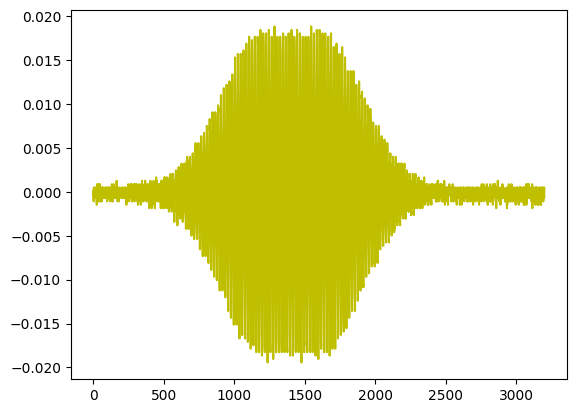

In [5]:
# test acquisition
acq_ctrl.do_acquisition()
chaA, chaB = acq_ctrl.numpy_get_alldata_from_buffer_in_volt()
print(chaA.shape)
plt.plot(chaA[0], 'y')
plt.show()

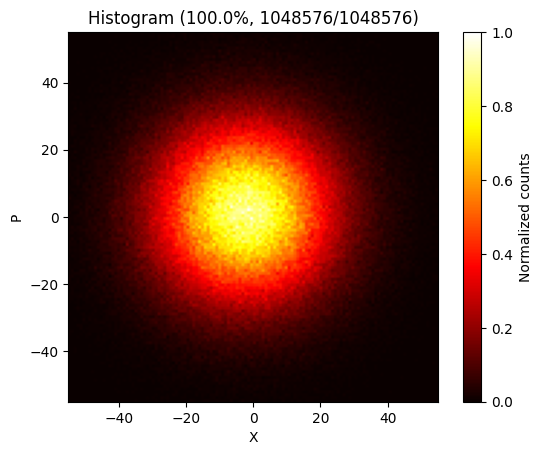

In [6]:
## tomography measurement
from tomography.measurekit import Histogram, Demodulator, TemporalModeMatcher

# acquisition settings
batch_size = NUMBER_OF_RECORDS
n_shots = 2**20
n_batches = n_shots // batch_size
update_interval = n_batches // 32

# initialize process utilities
hist = Histogram(n_row_col=2**7, max_x_p=55)
de = Demodulator(fc=50e6, fs=1e9, n_samples=NUMBER_OF_SAMPLES)
tmm = TemporalModeMatcher(fs=1e9)
tmm.regist_filter(np.ones(NUMBER_OF_SAMPLES-300)) # uniform filter as testing

for n in range(n_batches):
    # aqusition
    acq_ctrl.do_acquisition()
    chaA_acq, chaB_acq = acq_ctrl.numba_get_alldata_from_buffer_in_volt(copy=False)

    # process
    for trace in chaB_acq: # use chaB as noise for testing
        # demodulate
        noise = de.fast_shift_demod(trace, copy=False)
        # perform Temporal Mode Matching
        h, _ = tmm.perform_tmm(noise)
        # add to histogram
        hist.accumulate_to_histogram(h)

    # plotting
    if (n + 1) % update_interval == 0:
        clear_output(wait=True)
        hist.plot(title=f"Histogram ({(n + 1)/n_batches* 100:.1f}%, {batch_size*(n + 1)}/{n_shots})")
        plt.show()